# Decision tree classifier

In [7]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
class Node:
    '''
    the class representing a single node in a decision tree
    '''
    def __init__(self, depth, X=None, y=None):
        '''
        isleaf : a Boolean variable indicating whether the node is a leaf node or not.
        depth : the depth of the node
        X : the indices of data set associated with the nodes (to be splitted by the node)
        y : label associated with the data
        feature : the index of axis by which the node separate data
        thresh : the threshold $\theta$ of splitting applied to the feature.
        label : the most frequent class in the points associated with the node.
        left : the left child node of the node
        right : the right child node of the node
        '''
        self.isleaf = None
        self.depth = depth
        self.X = X
        self.y = y
        self.n, self.m = np.shape(self.X)
        self.feature = None
        self.thresh = None
        self.label = np.argmax(np.bincount(y))
        self.left = None
        self.right = None
        
        
    def impurity(self, y, criterion):
        '''
        The method calculates the impurity criterion (entropy or gini) for a given label array y.
        '''
        
        Ns = np.bincount(y)
        N = len(y)
        ps = Ns/N
        
        if criterion == 'gini':
            return np.sum(Ns/N * (1- Ns/N))
        
        elif criterion == 'entropy':
            ps[ps==0] = 1 # avoids log(0)
            return -np.sum(ps * np.log(ps))
            
            
        
    def calc_impurity_splitted(self, y_left, y_right, criterion='entropy'):
        '''
        The method calculates the impurity criterion after the splitting, where the values is given by weighted sum of impurity indices of two regions.
        '''
        Nl = len(y_left)
        Nr = len(y_right)
        N =  Nl + Nr 
        return Nl/N*self.impurity(y_left, criterion) + Nr/N*self.impurity(y_right, criterion)
        
    
    def find_best_split(self, criterion):
        best_feature = None
        best_thresh = None
        val = float("inf")
        for feature in range(self.m):
            sort_ind = np.argsort(self.X[:, feature])
            X_sorted = self.X[sort_ind]
            y_sorted = self.y[sort_ind]
            for i in range(1, self.n):
                y_left = y_sorted[:i]
                y_right = y_sorted[i:]
                tmp_val = self.calc_impurity_splitted(y_left, y_right, criterion)
                if tmp_val < val:
                    val = tmp_val
                    best_feature = feature
                    best_thresh = (X_sorted[i-1, feature] + X_sorted[i, feature]) / 2
        self.feature = best_feature
        self.thresh = best_thresh
    
    def split(self, max_depth, min_samples_split, criterion):
        '''
        The method splits data points recursively, where the splitting is based on the feature and threshold given by the result of find_best_split
        '''
        if len(self.y) < min_samples_split:
            self.isleaf = True
        elif self.depth >= max_depth:
            self.isleaf = True
        elif len(np.unique(self.y)) <= 1:
            self.isleaf = True
        else:
            self.isleaf = False
            self.find_best_split(criterion)
            left_ind = np.where(self.X[:, self.feature] < self.thresh)
            right_ind = np.where(self.X[:, self.feature] >= self.thresh)
            self.left = Node(depth=self.depth+1, X=self.X[left_ind], y=self.y[left_ind])
            self.right = Node(depth=self.depth+1, X=self.X[right_ind], y=self.y[right_ind])
            self.left.split(max_depth, min_samples_split, criterion)
            self.right.split(max_depth, min_samples_split, criterion)
            
    def judge(self, x):
        '''
        This recursive method makes prediction as to which class the input x falls into. If the node is not a leaf (self.isleaf==False), then it will descend the tree to ask sub-nodes.
        '''
        if self.isleaf:
            return self.label
        else:
            if x[self.feature] < self.thresh:
                return self.left.judge(x)
            else:
                return self.right.judge(x)

In [14]:
class DecisionTreeClassifier:
    def __init__(self, max_depth, min_samples_split, criterion):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
    
    def fit(self, X, y):
        self.root_node = Node(depth=0, X=X, y=y)
        self.root_node.split(max_depth=self.max_depth, min_samples_split=self.min_samples_split, criterion=self.criterion)
        return self
        
    def predict(self, X):
        y = np.zeros(len(X), dtype='int')
        for i in range(len(X)):
            y[i] = self.root_node.judge(X[i])
        return y

# 5 Experiment

In [15]:
from sklearn import datasets

N = 100
X, y = datasets.make_moons(n_samples = N, noise = 0.2)

xx1 = np.linspace(np.min(X[:,0]),np.max(X[:,0]),101)
xx2 = np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)
Xtest = np.array([[x1,x2] for x1 in xx1  for x2 in xx2])
xxx1, xxx2 = np.meshgrid(xx1, xx2)

def plot_result(clf):
    plt.figure(figsize = (10,7) )
    plt.plot(X[:,0][y==1], X[:,1][y==1],"o",label="1")
    plt.plot(X[:,0][y==0], X[:,1][y==0],"o",label="0")
    plt.legend()
    pred_val = clf.predict(Xtest)
    pred_val_2D = np.reshape(pred_val,(len(xx1),len(xx2))).T
    plt.pcolormesh(xxx1, xxx2, pred_val_2D, shading='auto')
    plt.colorbar()
    plt.show()

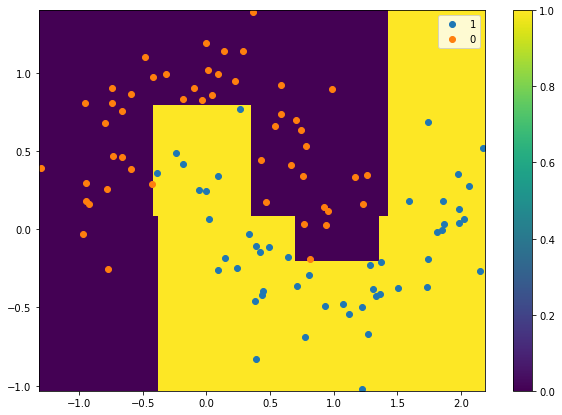

In [11]:
dtc = DecisionTreeClassifier(max_depth=40, min_samples_split=2, criterion='entropy')
dtc.fit(X, y)
plot_result(dtc)

We can see that decreasing the max_depth or increasing min_sample_split makes the decision tree (or its decision boundary) more regular. 
Thus, we can regularize the model by tweaking these parameters.

decreasing max_depth ...

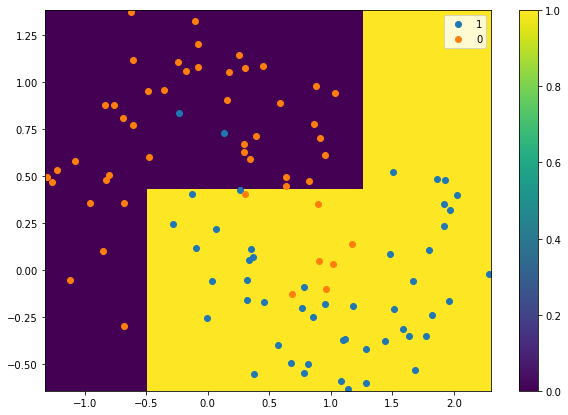

In [6]:
dtc2 = DecisionTreeClassifier(max_depth=4, min_samples_split=2, criterion='entropy')
dtc2.fit(X, y)
plot_result(dtc2)

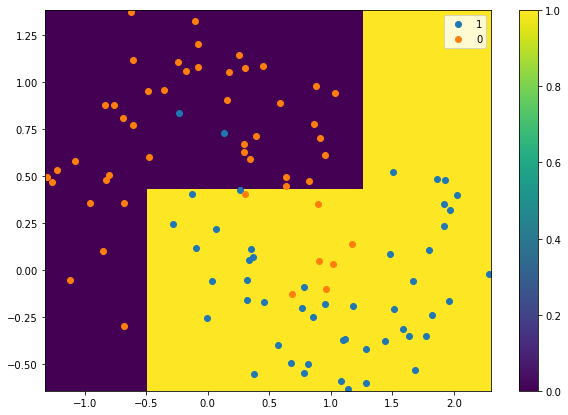

In [7]:
dtc3 = DecisionTreeClassifier(max_depth=2, min_samples_split=2, criterion='entropy')
dtc3.fit(X, y)
plot_result(dtc3)

increasing min_samples_split ...

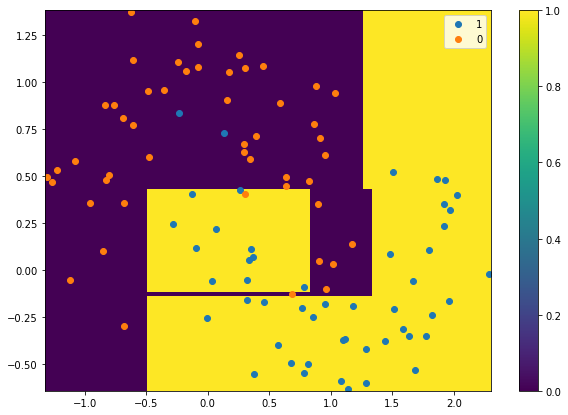

In [8]:
dtc4 = DecisionTreeClassifier(max_depth=40, min_samples_split=10, criterion='entropy')
dtc4.fit(X, y)
plot_result(dtc4)

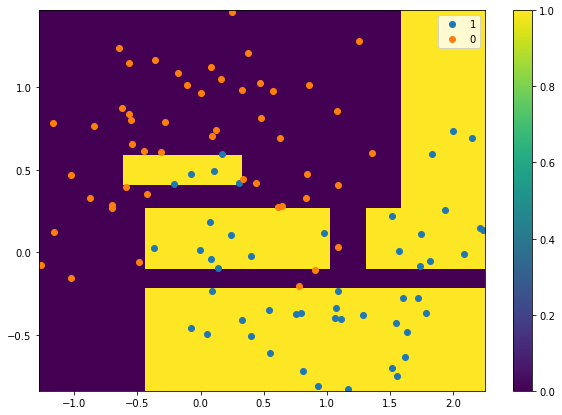

In [18]:
dtc5 = DecisionTreeClassifier(max_depth=100, min_samples_split=1, criterion='entropy')
dtc5.fit(X, y)
plot_result(dtc5)

## Bias-variance trade-off

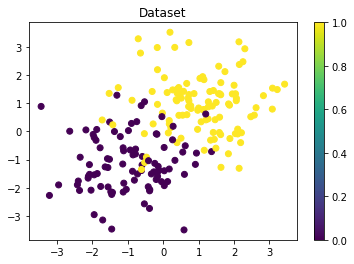

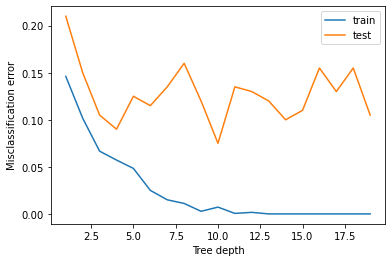

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# generate gaussian mixture
def generate_data(N, pi, mu, sigma):
    
    X = np.zeros((N, 2))
    z = np.zeros(N, dtype=np.int32)
    
    for i in range(N):
        # random sample latent/unobserved variable z
        z[i] = np.random.choice([0,1], p=pi)
        # random sample from z^th multivariate Gaussian
        X[i,:] = np.random.multivariate_normal(mu[z[i]], sigma[z[i]])
    
    return X, z

N = 200
# true parameters theta=(pi,mu,sigma)
pi = np.array([1/2, 1/2])
mu = np.array([[-1, -1], [1, 1]])
sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]]])
               
X, y = generate_data(N, pi, mu, sigma)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y)
plt.colorbar()
plt.title('Dataset')
plt.show()

cv = 10

depths = np.arange(1, 20)
train_accs = []
test_accs = []

for depth in depths:

    dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=2, criterion='entropy')

    train_acc = 0
    test_acc = 0

    for i in range(cv):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/cv)

        dtc.fit(X_train, y_train)

        y_train_pred = dtc.predict(X_train)
        train_acc += 1 - accuracy_score(y_train, y_train_pred)

        y_test_pred = dtc.predict(X_test)
        test_acc += 1 - accuracy_score(y_test, y_test_pred)

    train_accs.append(train_acc/cv)
    test_accs.append(test_acc/cv)

plt.figure()
plt.plot(depths, train_accs, label='train')
plt.plot(depths, test_accs, label='test')
plt.legend()
plt.ylabel('Misclassification error')
plt.xlabel('Tree depth')
plt.show()